In [2]:
from glob import glob

import numpy as np
# import modin.pandas as mpd
import matplotlib.pyplot as plt
import pandas as pd
import ray

plt.style.use("ggplot")
# ray.init(num_cpus=3)

## Load data from 2019 and 2020

Also found [official study (snapshot)](https://scag.ca.gov/sites/main/files/file-attachments/labikeshare_scag.pdf?1604261539) of bike share program in 2018. May help frame questions further.

Parsing datetimes is time-consuming; parallelizing with `modin` can alleviate the problem --- speed up is almost linear with number of CPUs. *However*, `modin` doesn't work well with `Grouper` which facilitates calculating statistics within (non-overlapping) time windows. Hence, I will stick with `pandas`...

In [3]:
trip_csv_kwargs = {
    "parse_dates": ["start_time", "end_time"],
    "dtype": dict(
        duration=np.int32, start_station=np.int32, start_lat=np.float32, start_lon=np.float32,
        end_lat=np.float32, end_lon=np.float32
    )
}

df_2020 = pd.concat([
    pd.read_csv(fpath, **trip_csv_kwargs) for fpath in glob("data/metro-trips-2020-q*.csv")
], axis=0, ignore_index=True)

In [4]:
df_2019 = pd.concat([
    pd.read_csv(fpath, **trip_csv_kwargs) 
    for fpath in glob("data/metro-bike-share-trips-2019-*.csv")
], axis=0, ignore_index=True)

/Users/everestl/miniconda3/envs/DS/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
# Without specifiying column names, there'd be an empty space following Region
station_csv_kwargs = {
    "header": 0,
    "names": "Station_ID,Station_Name,Go_live_date,Region,Status".split(","),
    "dtype": dict(Station_ID=np.int32), 
    "parse_dates": ["Go_live_date"],
    "index_col": "Station_ID"
}

station = pd.read_csv("data/metro-bike-share-stations-2021-01-01.csv", **station_csv_kwargs)

### Missing values?

Missing values concentrated in columns `start_lat, start_lon, end_lat, end_lon`, even when the corresponding station IDs themselves are available in the stations DataFrame. I don't need the latitudes and longitudes here, but in principle the imputation is easy.

In [6]:
df_2020.isna().sum()

trip_id                   0
duration                  0
start_time                0
end_time                  0
start_station             0
start_lat              2701
start_lon              2701
end_station               0
end_lat                6620
end_lon                6620
bike_id                   0
plan_duration             0
trip_route_category       0
passholder_type        4726
bike_type                 0
dtype: int64

In [7]:
df_2019.isna().sum()

trip_id                    0
duration                   0
start_time                 0
end_time                   0
start_station              0
start_lat               4837
start_lon               4837
end_station                0
end_lat                10585
end_lon                10585
bike_id                    0
plan_duration              0
trip_route_category        0
passholder_type            0
bike_type                  0
dtype: int64

In [8]:
assert (df_2020.start_station.isin(station.index)).sum() == df_2020.shape[0]

In [10]:
# A small amount of trips with missing stations
# Not surprising considering
df_2019.start_station.isin(station.index).sum() - df_2019.shape[0]

-33

## EDA

### Persistent drop in weekly mobility; loss of summer peak

The pandemic became publicly recognized in the US in mid-March; at the same time, the number of weekly trips initiated has plummeted. This is expected given the stay-at-home order and the fear of getting infected by a novel virus. Even as public health measures relaxed in the summer, the number of weekly trips remained low at 50% of pre-pandemic times.

Interestingly, although the 2020 winter surge was much worse than any preceding infection waves, the number of weekly trips remained steady through the end of 2020.

The drop in weekly trips is especially apparent when comparing with 2019 data. In fact, 2019 summer was peak seasion of that year, whereas it is reverse opposite for 2020 (spring lockdown notwithstanding).

In [11]:
gb_2019 = df_2019.groupby(pd.Grouper(key="start_time", freq="W-WED"))
gb_2020 = df_2020.groupby(pd.Grouper(key="start_time", freq="W-WED"))

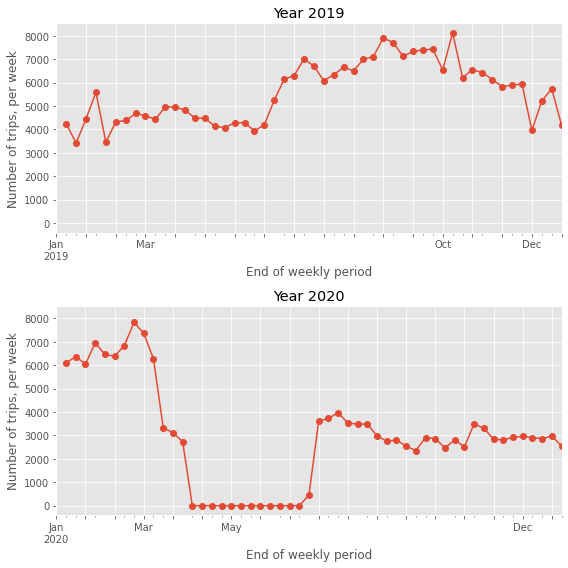

In [12]:
# Must not plot the last data point, because it actually doesn't cover a full week
# In other words, the number is so low that it shows up as an outlier
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharey=True, tight_layout=True)

gb_2019["trip_id"].count().iloc[1:-1].plot(ax=axes[0], style="-o")
gb_2020["trip_id"].count().iloc[1:-1].plot(ax=axes[1], style="-o")

for yr, ax in zip(("2019", "2020"), axes):
    ax.set_xlabel("End of weekly period")
    ax.set_ylabel("Number of trips, per week")
    ax.set_title(f"Year {yr}")
    ax.set_xticks(pd.date_range(start=f"{yr}-01-01", end=f"{yr}-12-31", freq="3W-WED"))
    
# fig.suptitle("Trip Number Pattern, 2019 v.s. 2020")
# fig.autofmt_xdate()

### Were starting/ending locations affected equally?

Above we displayed a county-wide trend; but what if we look at individual regions within the county? How were mobility patterns affected --- do people make trips with different starting points or destinations?

In [13]:
df_2020 = df_2020.merge(station[["Region"]], left_on="start_station", right_index=True)\
                 .rename(columns={"Region": "start_region"})

df_2020 = df_2020.merge(station[["Region"]], left_on="end_station", right_index=True)\
                 .rename(columns={"Region": "end_region"})

Text(0.5, 0, 'End of weekly period')

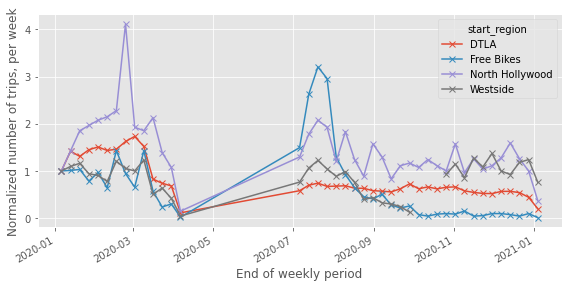

In [14]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True)

normalized_trip_by_location = df_2020.groupby(["start_region", pd.Grouper(key="start_time", freq="W-MON")])["trip_id"]\
                                     .count().unstack(level=0)

normalized_trip_by_location = normalized_trip_by_location / normalized_trip_by_location.iloc[0]
normalized_trip_by_location.plot(style="-x", ax=ax)
plt.ylabel("Normalized number of trips, per week")
plt.xlabel("End of weekly period")

## Proportion of 2019/2020 cross-region trips

4% of trips are cross-region in 2019 and 2020. Considering that LA is a sprawl and the regions are ~10 miles away from each other, it's interesting that cross-region riders exist. For example, why do they not use their own bikes? Are there affordibility concerns?

In [15]:
(df_2020.start_region != df_2020.end_region).mean()

0.04313355416891354

In [16]:
df_2019 = df_2019.merge(station[["Region"]], left_on="start_station", right_index=True)\
                 .rename(columns={"Region": "start_region"})

df_2019 = df_2019.merge(station[["Region"]], left_on="end_station", right_index=True)\
                 .rename(columns={"Region": "end_region"})

In [17]:
(df_2019.start_region != df_2019.end_region).mean()

0.04043281751663888